In [1]:
import numpy as np
import pandas as pd
import bson
import seaborn as sns
import string
import re
from unidecode import unidecode
import itertools
import cleantext
import nltk


from sklearn.model_selection import train_test_split

In [2]:
avis_df = pd.read_csv('data/avis.csv')
details_df = pd.read_csv('data/details.csv')
infos_scrapping_df = pd.read_csv('data/infos_scrapping.csv')
jeux_df = pd.read_csv('data/jeux.csv')

In [3]:
avis_df.head()

,Unnamed: 0,_id,author,date_published,title_review,note,review_href,title,url,treated,comment
0,0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,1,63c6726ea81f3e3016af9a57,morlockbob,2020-10-18 10:04:21,le festival de Michoacan,7.0,https://www.trictrac.net/avis/le-festival-de-m...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Comment continuer après un mega hit ? Simpleme...
2,2,63c6726ea81f3e3016af9a58,SwatSh,2021-02-01 08:35:08,Vivez la migration des monarques,7.0,https://www.trictrac.net/avis/vivez-la-migrati...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,3,63c6726ea81f3e3016af9a59,Timi JeuxATheme,2020-11-19 17:04:57,Bon,8.0,NaN,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN
4,4,63c6726ea81f3e3016af9a5a,prunelles,2021-05-24 12:43:18,Envolez-moi,9.0,https://www.trictrac.net/avis/envolez-moi,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Très joli bijou que ce jeu-là ! Le matériel, l..."


In [4]:
avis_df.shape

(246524, 11)

In [5]:
avis_df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [6]:
for column in avis_df.columns:
    print(column)

_id
author
date_published
title_review
note
review_href
title
url
treated
comment


In [7]:
avis_df.isnull().sum().sort_values(ascending=0)

comment           59531
review_href       45428
_id                   0
author                0
date_published        0
title_review          0
note                  0
title                 0
url                   0
treated               0
dtype: int64

#### On decide de retirer toutes les lignes comment NULL

In [8]:
avis_df_treated = avis_df.dropna(inplace=False)

In [9]:
avis_df_treated.shape

(186993, 10)

In [10]:
avis_df_treated

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment
0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,63c6726ea81f3e3016af9a57,morlockbob,2020-10-18 10:04:21,le festival de Michoacan,7.0,https://www.trictrac.net/avis/le-festival-de-m...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Comment continuer après un mega hit ? Simpleme...
2,63c6726ea81f3e3016af9a58,SwatSh,2021-02-01 08:35:08,Vivez la migration des monarques,7.0,https://www.trictrac.net/avis/vivez-la-migrati...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
4,63c6726ea81f3e3016af9a5a,prunelles,2021-05-24 12:43:18,Envolez-moi,9.0,https://www.trictrac.net/avis/envolez-moi,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Très joli bijou que ce jeu-là ! Le matériel, l..."
5,63c6726ea81f3e3016af9a5b,BSI40,2022-09-23 17:16:27,Manque un peu de souffle,7.0,https://www.trictrac.net/avis/manque-un-peu-de...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est plutôt beau avec un grand platea...
...,...,...,...,...,...,...,...,...,...,...
246512,63c7f00aca188a9a85b03348,Abzaron,2008-06-12 12:28:50,Zombies pas clairs,6.0,https://www.trictrac.net/avis/zombies-pas-clairs,Zombie Town,https://www.trictrac.net/jeu-de-societe/zombie...,True,Un jeu attrayant : il semble facile à jouer ca...
246513,63c7f00aca188a9a85b03349,zorglub,2007-06-13 12:28:46,ZOMBIE 1 ou ZOMBIE DON (?),6.0,https://www.trictrac.net/avis/zombie-1-ou-zomb...,Zombie Town,https://www.trictrac.net/jeu-de-societe/zombie...,True,Bon alors comment dire... on a joué a 6 et c'e...
246514,63c7f00aca188a9a85b0334a,Seb M.,2018-09-18 14:20:13,Essai pas complètement transformé...,6.2,https://www.trictrac.net/avis/essai-pas-comple...,Zombie Town,https://www.trictrac.net/jeu-de-societe/zombie...,True,"Jeu indéniablement sympa, très visuel lorsque ..."
246515,63c7f00aca188a9a85b0334b,sylla,2012-04-24 12:29:04,"Le ""Can't Stop"" des campus américains",6.0,https://www.trictrac.net/avis/le-can-t-stop-de...,Cosmic Wimpout,https://www.trictrac.net/jeu-de-societe/cosmic...,True,Cosmic Wimpout est né dans les années 70 sur l...


In [11]:
X, y = avis_df_treated.drop(['note'], axis=1), avis_df_treated['note']

## Creation du train/test set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## exploration des données des notes

<AxesSubplot: >

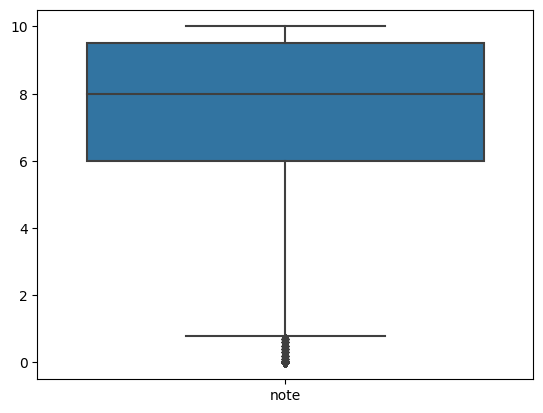

In [13]:
sns.boxplot(data=pd.DataFrame(y_train))

<AxesSubplot: xlabel='note', ylabel='Count'>

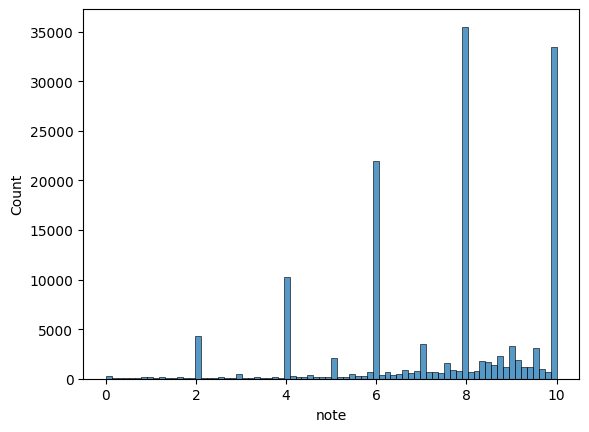

In [14]:
sns.histplot(data=pd.DataFrame(y_train), x='note')

***1) La majorité des notes sont des entiers pairs*** <br>
***2) La majorité des notes sont positives*** <br>
***-> vigilance lors de la classification car il est beaucoup plus facile de prédire des notes positives et d'obtenir une accuracy elevee***<br>

## ONE-HOT ENCODING

## Data processing

In [18]:
union_string = ' '.join(X_train['comment'])

In [19]:
len(union_string)

99712889

In [54]:
#nltk.download('punkt')
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clementmarie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [21]:
stopwords = set(stopwords.words('french'))
stemmer = SnowballStemmer("french")

words_tokenized = word_tokenize(union_string)
lower_words = [w.lower() for w in words_tokenized]

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
stripped = [w.translate(table) for w in lower_words]

alpha_words = [word for word in stripped if word.isalpha()]

words = [w for w in alpha_words if not w in stopwords]
stemmed_words = [stemmer.stem(w) for w in words]
set_words = [unidecode(w) for w in stemmed_words]

In [22]:
def clean_sentence(sentence, stopwords, stemmer):
    words_tokenized = word_tokenize(sentence)
    lower_words = [w.lower() for w in words_tokenized]

    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    stripped = [w.translate(table) for w in lower_words]

    alpha_words = [word for word in stripped if word.isalpha()]

    words = [w for w in alpha_words if not w in stopwords]
    stemmed_words = [stemmer.stem(w) for w in words]
    set_words = [unidecode(w) for w in stemmed_words]
    return set_words

In [26]:
def one_hot_encode(set_words, sentence):
    one_hot_encoded = [0]*len(set_words)
    words = clean_sentence(sentence, stopwords, stemmer)
    
    for word in words:
        if word in set_words:
            one_hot_encoded[set_words.index(word)] = 1
    return np.array(one_hot_encoded)

In [29]:
one_hot_encoded = [one_hot_encode(set_words, sentence) for sentence in X_train['comment'].iloc[:100]]

In [34]:
one_hot_encoded = X_train['comment'].iloc[:100].apply(lambda x: one_hot_encode(set_words, x))

In [35]:
one_hot_encoded

13795     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
159746    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
222857    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
62251     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
187858    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...
                                ...                        
169449    [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
121733    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
213509    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10608     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
183006    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
Name: comment, Length: 100, dtype: object

### Inconvenients:
1) Le vocabulaire est enorme donc la taille du vecteur sera enorme
2) On perd l'ordre dans lequel les mots apparaissent = perte de contexte
3) information sur la frequence d'apparition des mots est egalement perdue

### complexite?
